In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import os 
#os.mkdir("./gdrive/MyDrive/RL_PA2_Cartpole1")
os.chdir("./gdrive/MyDrive/RL_PA2_Cartpole1")

Mounted at /content/gdrive


In [3]:
os.getcwd()

'/content/gdrive/MyDrive/RL_PA2_Cartpole1'

In [4]:

import numpy as np
import random
import torch
import torch.nn as nn  
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
#from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

In [1]:
class ActorCriticModel(tf.keras.Model):
    """
    Defining policy and value networkss
    """
    def __init__(self, action_size, n_hidden1=1024, n_hidden2=512):
        super(ActorCriticModel, self).__init__()
        self.model_name=self.__class__.__name__ 
        #Hidden Layer 1
        self.fc1 = tf.keras.layers.Dense(n_hidden1, activation='relu')
        #Hidden Layer 2
        self.fc2 = tf.keras.layers.Dense(n_hidden2, activation='relu')
        
        
        #Output Layer for policy
        self.pi_out = tf.keras.layers.Dense(action_size, activation='softmax')
        #Output Layer for state-value
        self.v_out = tf.keras.layers.Dense(1)

    def call(self, state):
        """
        Computes policy distribution and state-value for a given state
        """
        layer1 = self.fc1(state)
        layer2 = self.fc2(layer1)

        pi = self.pi_out(layer2)
        v = self.v_out(layer2)

        return pi, v

NameError: ignored

In [5]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)
class Agent:
    """
    Agent class
    """
    def __init__(self, action_size, lr=0.001, gamma=0.99, seed = 85):
        self.gamma = gamma
        self.ac_model = ActorCriticModel(action_size=action_size)
        self.ac_model.compile(tf.keras.optimizers.Adam(learning_rate=lr))
        np.random.seed(seed)
        self.agent_name=self.ac_model.model_name
        
    
    def sample_action(self, state):
        """
        Given a state, compute the policy distribution over all actions and sample one action
        """
        pi,_ = self.ac_model(state)

        action_probabilities = tfp.distributions.Categorical(probs=pi)
        sample = action_probabilities.sample()

        return int(sample.numpy()[0])

    def actor_loss(self, action, pi, delta):
        """
        Compute Actor Loss
        """
        return -tf.math.log(pi[0,action]) * delta

    def critic_loss(self,delta):
        """
        Critic loss aims to minimize TD error
        """
        return delta**2

    @tf.function
    def learn(self, state, action, reward, next_state=None, done=False,n=1,full_return=False):
        """
        For a given transition (s,a,s',r) update the paramters by computing the
        gradient of the total loss
        """
        if full_return:
          with tf.GradientTape(persistent=True) as tape:
            pi, V_s = self.ac_model(state)
            

            V_s = tf.squeeze(V_s)
            delta=reward-V_s

            loss_a = self.actor_loss(action, pi, delta)
            loss_c =self.critic_loss(delta)
            loss_total = loss_a + loss_c

          gradient = tape.gradient(loss_total, self.ac_model.trainable_variables)
          self.ac_model.optimizer.apply_gradients(zip(gradient, self.ac_model.trainable_variables))


        else:
          with tf.GradientTape(persistent=True) as tape:
              pi, V_s = self.ac_model(state)
              _, V_s_next = self.ac_model(next_state)
              #loss_c =huber_loss(reward + (((self.gamma)**n)*(V_s_next*(1))),V_s)
              V_s = tf.squeeze(V_s)
              V_s_next = tf.squeeze(V_s_next)
              

              #### TO DO: Write the equation for delta (TD error)
              ## Write code below
              delta = reward + (((self.gamma)**n)*(V_s_next*(1))) - V_s
              if full_return:
                delta=reward-V_s

              loss_a = self.actor_loss(action, pi, delta)
              loss_c =self.critic_loss(delta)
              loss_total = loss_a + loss_c

          gradient = tape.gradient(loss_total, self.ac_model.trainable_variables)
          self.ac_model.optimizer.apply_gradients(zip(gradient, self.ac_model.trainable_variables))


In [ ]:
env = gym.make('CartPole-v1')
reward_threshold=195 #env.spec.reward_threshold
reward_variations={"One_step":[1],"n-step":[4,16]}
reward_variations={"One_step":[1]}
learning_rate_parameters=[1e-2]
episode_parameters=[600]
runs=10


/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [6]:

def step_variance_plots(reward_variation,step_variation,title="ad"):
  reward_variation=np.array(reward_variation)
  mean=np.mean(reward_variation, axis=0)
  mean_st=np.mean(step_variation)
  var = np.sqrt((np.sum((reward_variation-mean)**2,axis=0)))/runs
  print(step_variation)


  plt.figure(figsize=(8,8))
  plt.plot([i+1 for i in range(mean.shape[0])],mean)
  plt.plot([i+1 for i in range(mean.shape[0])],[reward_threshold for i in range(mean.shape[0])])
  plt.title(f"Reward Plot+(Avg_steps_to_comp={mean_st})")
  plt.suptitle(title)
  plt.xlabel("Episodes")
  plt.ylabel("Avgerage reward over 10 runs")
  plt.savefig(f"./Reward_plot {title}.jpg")



  plt.figure(figsize=(8,8))
  plt.plot([i+1 for i in range(mean.shape[0])],var)
  plt.title("Variance")
  plt.suptitle(title)
  plt.xlabel("Episodes")
  plt.ylabel("Avg Variance over 10 runs")
  plt.savefig(f"./Var_{title}.jpg")

def discounted_reward(rewards,gamma=0.99):
  sum=0 
  g=1 

  for i in range(rewards.shape[0]):
    sum+=(rewards[i]*g)
    g=g*gamma 
  return sum.astype(np.float32)


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode  0 Reward 11.000000 Average Reward nan No of steps 11.000000
Episode  10 Reward 10.000000 Average Reward 9.300000 No of steps 10.000000
Episode  20 Reward 10.000000 Average Reward 9.200000 No of steps 10.000000
Episode  30 Reward 10.000000 Average Reward 9.350000 No of steps 10.000000
Episode  40 Reward 10.000000 Average Reward 9.600000 No of steps 10.000000
Episode  50 Reward 10.000000 Average Reward 9.450000 No of steps 10.000000
Episode  60 Reward 9.000000 Average Reward 9.250000 No of steps 9.000000
Episode  70 Reward 9.000000 Average Reward 9.050000 No of steps 9.000000
Episode  80 Reward 9.000000 Average Reward 9.050000 No of steps 9.000000
Episode  90 Reward 9.000000 Average Reward 9.100000 No of steps 9.000000
Episode  100 Reward 9.000000 Average Reward 9.250000 No of steps 9.000000
Episode  110 Reward 9.000000 Average Reward 9.300000 No of steps 9.000000
Episode  120 Reward 10.000000 Average Reward 9.200000 No of steps 10.000000
Episode  130 Reward 10.000000 Average Re

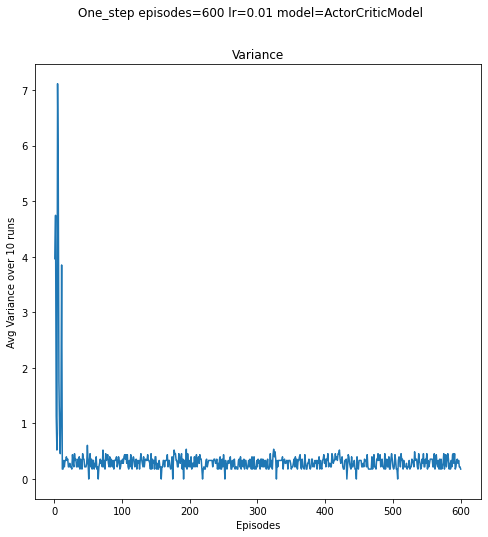

In [ ]:

for variation in reward_variations.keys():
  for n in reward_variations[variation]:
    for epi in episode_parameters:
      for lr in learning_rate_parameters:
            reward_variation=[]
            no_of_steps_list=[epi for i in range(runs)]
            for run in range(runs):
              state_shape = env.observation_space.shape[0]
              action_shape = env.action_space.n
              #Initializing Agent
              agent = Agent(lr=lr, action_size=env.action_space.n)
              #Number of episodes
              episodes = epi
              tf.compat.v1.reset_default_graph()

              reward_list = [reward_threshold for i in range(episodes)]
              average_reward_list = []
              
              begin_time = datetime.datetime.now()
                
              for ep in range( episodes):
                
                  avg_100 =  np.mean(reward_list[max(0,ep-20):ep])
                  if avg_100 > reward_threshold:
                      print('Stopped at Episode ',ep-20)
                      no_of_steps_list[run]=ep-20+1
                      break
                  state = env.reset().reshape(1,-1)
                  done = False
                  ep_rew = 0 
                  no_of_steps=0
                  
                  if variation=="One_step":
                    var_title=variation
                    while not done:
                      action = agent.sample_action(state) ##Sample Action
                      next_state, reward, done, info = env.step(action) ##Take action
                      next_state = next_state.reshape(1,-1)
                      ep_rew += reward  ##Updating episode reward
                      agent.learn(state, action, reward, next_state, done) ##Update Parameters
                      state = next_state ##Updating State
                      no_of_steps+=1 
                  elif variation=="full_return":
                      var_title=variation
                      curr_rew=0 
                      gam=1 
                      action_array=[]
                      state_array=[]
                      reward_array=[]
                      while not done:
                        action = agent.sample_action(state) ##Sample Action
                        next_state, reward, done, info = env.step(action) ##Take action
                        action_array.append(action)
                        state_array.append(state) 
                        reward_array.append(reward)
                        next_state = next_state.reshape(1,-1)
                        ep_rew += reward  ##Updating episode reward
                  
        
                        state = next_state ##Updating State
                        no_of_steps+=1 
                      for i in range(len(action_array)):
                        state=state_array[i]
                        curr_rew=discounted_reward(np.array(reward_array[i:]))
                        action=action_array[i]
                        agent.learn(state, action, curr_rew, next_state, done,full_return=True)
                  else: 
                      var_title=f"{n}_step_return"
                      while not done:
                        curr_rew=0 
                        gam=1
                        for i in range(n):
                          
                          
                          action = agent.sample_action(state) ##Sample Action
                          next_state, reward, done, info = env.step(action) ##Take action
                          
                          next_state = next_state.reshape(1,-1)
                          if done:
                            break 
                          curr_rew+=(reward*gam)
                          gam=gam*agent.gamma
                          ep_rew += reward 
                          no_of_steps+=1 
                          prev_state=state
                          state = next_state
                        agent.learn(prev_state, action, curr_rew, state, done,n=n)
                        

                      
                  
                  
                  reward_list[ep]=(ep_rew)
                  
                  if ep % 10 == 0:
                    print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_100,"No of steps %f" %no_of_steps)
                  
              reward_variation.append(np.array(reward_list))
              time_taken = datetime.datetime.now() - begin_time
              print(time_taken)
              if no_of_steps_list[run]==0:
                no_of_steps_list[run]=ep+1
            title=f"{var_title} episodes={epi} lr={lr} model={agent.agent_name}"
            step_variance_plots(reward_variation,no_of_steps_list,title)

In [ ]:
env = gym.make('CartPole-v1')
reward_threshold=195 #env.spec.reward_threshold
reward_variations={"One_step":[1],"n-step":[4,16]}
reward_variations={"full_return":[1]}
learning_rate_parameters=[1e-4]
episode_parameters=[2000]
runs=5


for variation in reward_variations.keys():
  for n in reward_variations[variation]:
    for epi in episode_parameters:
      for lr in learning_rate_parameters:
            reward_variation=[]
            no_of_steps_list=[epi for i in range(runs)]
            for run in range(runs):
              state_shape = env.observation_space.shape[0]
              action_shape = env.action_space.n
              #Initializing Agent
              agent = Agent(lr=lr, action_size=env.action_space.n)
              #Number of episodes
              episodes = epi
              tf.compat.v1.reset_default_graph()

              reward_list = [reward_threshold for i in range(episodes)]
              average_reward_list = []
              
              begin_time = datetime.datetime.now()
                
              for ep in range( episodes):
                
                  avg_100 =  np.mean(reward_list[max(0,ep-20):ep])
                  if avg_100 > reward_threshold:
                      print('Stopped at Episode ',ep-20)
                      no_of_steps_list[run]=ep-20+1
                      break
                  state = env.reset().reshape(1,-1)
                  done = False
                  ep_rew = 0 
                  no_of_steps=0
                  
                  if variation=="One_step":
                    var_title=variation
                    while not done:
                      action = agent.sample_action(state) ##Sample Action
                      next_state, reward, done, info = env.step(action) ##Take action
                      next_state = next_state.reshape(1,-1)
                      ep_rew += reward  ##Updating episode reward
                      agent.learn(state, action, reward, next_state, done) ##Update Parameters
                      state = next_state ##Updating State
                      no_of_steps+=1 
                  elif variation=="full_return":
                      var_title=variation
                      curr_rew=0 
                      gam=1 
                      action_array=[]
                      state_array=[]
                      reward_array=[]
                      while not done:
                        action = agent.sample_action(state) ##Sample Action
                        next_state, reward, done, info = env.step(action) ##Take action
                        action_array.append(action)
                        state_array.append(state) 
                        reward_array.append(reward)
                        next_state = next_state.reshape(1,-1)
                        ep_rew += reward  ##Updating episode reward
                  
        
                        state = next_state ##Updating State
                        no_of_steps+=1 
                      for i in range(len(action_array)):
                        state=state_array[i]
                        curr_rew=discounted_reward(np.array(reward_array[i:]))
                        action=action_array[i]
                        agent.learn(state, action, curr_rew, next_state, done,full_return=True)
                  else: 
                      var_title=f"{n}_step_return"
                      while not done:
                        curr_rew=0 
                        gam=1
                        for i in range(n):
                          
                          
                          action = agent.sample_action(state) ##Sample Action
                          next_state, reward, done, info = env.step(action) ##Take action
                          
                          next_state = next_state.reshape(1,-1)
                          if done:
                            break 
                          curr_rew+=(reward*gam)
                          gam=gam*agent.gamma
                          ep_rew += reward 
                          no_of_steps+=1 
                          prev_state=state
                          state = next_state
                        agent.learn(prev_state, action, curr_rew, state, done,n=n)
                        

                      
                  
                  
                  reward_list[ep]=(ep_rew)
                  
                  if ep % 10 == 0:
                    print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_100,"No of steps %f" %no_of_steps)
                  
              reward_variation.append(np.array(reward_list))
              time_taken = datetime.datetime.now() - begin_time
              print(time_taken)
              if no_of_steps_list[run]==0:
                no_of_steps_list[run]=ep+1
            title=f"{var_title} episodes={epi} lr={lr} model={agent.agent_name}"
            step_variance_plots(reward_variation,no_of_steps_list,title)

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode  0 Reward 14.000000 Average Reward nan No of steps 14.000000
Episode  10 Reward 18.000000 Average Reward 18.100000 No of steps 18.000000
Episode  20 Reward 20.000000 Average Reward 18.650000 No of steps 20.000000
Episode  30 Reward 19.000000 Average Reward 20.100000 No of steps 19.000000
Episode  40 Reward 9.000000 Average Reward 27.950000 No of steps 9.000000
Episode  50 Reward 20.000000 Average Reward 23.000000 No of steps 20.000000
Episode  60 Reward 14.000000 Average Reward 12.900000 No of steps 14.000000
Episode  70 Reward 13.000000 Average Reward 14.600000 No of steps 13.000000
Episode  80 Reward 18.000000 Average Reward 14.700000 No of steps 18.000000
Episode  90 Reward 18.000000 Average Reward 16.750000 No of steps 18.000000
Episode  100 Reward 19.000000 Average Reward 19.650000 No of steps 19.000000
Episode  110 Reward 14.000000 Average Reward 25.400000 No of steps 14.000000
Episode  120 Reward 28.000000 Average Reward 23.150000 No of steps 28.000000
Episode  130 Rewar

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode  0 Reward 27.000000 Average Reward nan No of steps 27.000000
Episode  10 Reward 42.000000 Average Reward 25.000000 No of steps 42.000000
Episode  20 Reward 62.000000 Average Reward 26.750000 No of steps 62.000000
Episode  30 Reward 31.000000 Average Reward 27.550000 No of steps 31.000000
Episode  40 Reward 25.000000 Average Reward 21.350000 No of steps 25.000000
Episode  50 Reward 33.000000 Average Reward 19.900000 No of steps 33.000000
Episode  60 Reward 8.000000 Average Reward 21.150000 No of steps 8.000000
Episode  70 Reward 10.000000 Average Reward 17.300000 No of steps 10.000000
Episode  80 Reward 8.000000 Average Reward 17.300000 No of steps 8.000000
Episode  90 Reward 9.000000 Average Reward 16.700000 No of steps 9.000000
Episode  100 Reward 8.000000 Average Reward 13.100000 No of steps 8.000000
Episode  110 Reward 9.000000 Average Reward 16.900000 No of steps 9.000000
Episode  120 Reward 12.000000 Average Reward 19.700000 No of steps 12.000000
Episode  130 Reward 15.000

Episode  10 Reward 41.000000 Average Reward 24.400000 No of steps 41.000000
Episode  20 Reward 8.000000 Average Reward 21.950000 No of steps 8.000000
Episode  30 Reward 26.000000 Average Reward 19.150000 No of steps 26.000000
Episode  40 Reward 34.000000 Average Reward 20.350000 No of steps 34.000000
Episode  50 Reward 14.000000 Average Reward 22.650000 No of steps 14.000000
Episode  60 Reward 11.000000 Average Reward 20.950000 No of steps 11.000000
Episode  70 Reward 11.000000 Average Reward 19.450000 No of steps 11.000000
Episode  80 Reward 8.000000 Average Reward 17.500000 No of steps 8.000000
Episode  90 Reward 17.000000 Average Reward 14.400000 No of steps 17.000000
Episode  100 Reward 32.000000 Average Reward 16.900000 No of steps 32.000000
Episode  110 Reward 15.000000 Average Reward 23.750000 No of steps 15.000000
Episode  120 Reward 19.000000 Average Reward 23.750000 No of steps 19.000000
Episode  130 Reward 32.000000 Average Reward 23.750000 No of steps 32.000000
Episode  140

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode  0 Reward 18.000000 Average Reward nan No of steps 18.000000


Episode  10 Reward 20.000000 Average Reward 23.200000 No of steps 20.000000
Episode  20 Reward 20.000000 Average Reward 22.050000 No of steps 20.000000
Episode  30 Reward 11.000000 Average Reward 23.750000 No of steps 11.000000
Episode  40 Reward 15.000000 Average Reward 20.900000 No of steps 15.000000
Episode  50 Reward 10.000000 Average Reward 16.400000 No of steps 10.000000
Episode  60 Reward 10.000000 Average Reward 21.250000 No of steps 10.000000
Episode  70 Reward 35.000000 Average Reward 21.500000 No of steps 35.000000
Episode  80 Reward 32.000000 Average Reward 17.950000 No of steps 32.000000
Episode  90 Reward 8.000000 Average Reward 18.300000 No of steps 8.000000
Episode  100 Reward 21.000000 Average Reward 17.800000 No of steps 21.000000
Episode  110 Reward 15.000000 Average Reward 17.400000 No of steps 15.000000
Episode  120 Reward 12.000000 Average Reward 16.250000 No of steps 12.000000
Episode  130 Reward 8.000000 Average Reward 14.200000 No of steps 8.000000
Episode  140

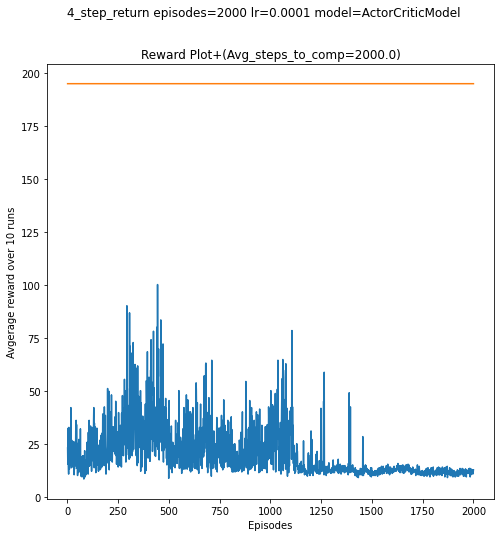

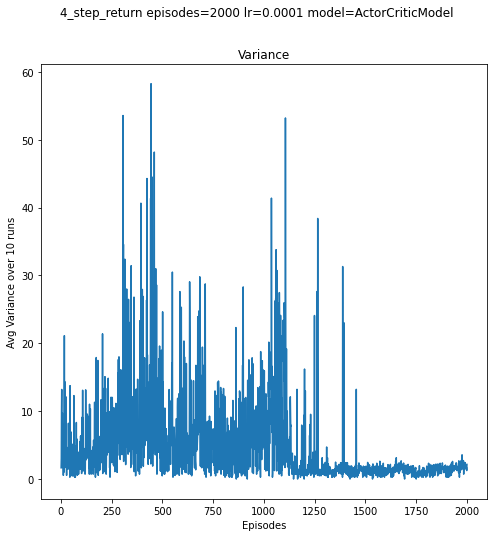

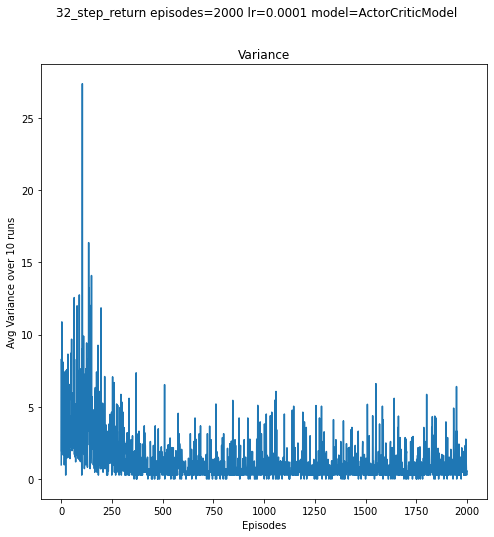

In [ ]:
env = gym.make('CartPole-v1')
reward_threshold=195 #env.spec.reward_threshold
reward_variations={"One_step":[1],"n-step":[4,16]}
reward_variations={"n-step":[4,32]}
learning_rate_parameters=[1e-4]
episode_parameters=[2000]
runs=5


for variation in reward_variations.keys():
  for n in reward_variations[variation]:
    for epi in episode_parameters:
      for lr in learning_rate_parameters:
            reward_variation=[]
            no_of_steps_list=[epi for i in range(runs)]
            for run in range(runs):
              state_shape = env.observation_space.shape[0]
              action_shape = env.action_space.n
              #Initializing Agent
              agent = Agent(lr=lr, action_size=env.action_space.n)
              #Number of episodes
              episodes = epi
              tf.compat.v1.reset_default_graph()

              reward_list = [reward_threshold for i in range(episodes)]
              average_reward_list = []
              
              begin_time = datetime.datetime.now()
                
              for ep in range( episodes):
                
                  avg_100 =  np.mean(reward_list[max(0,ep-20):ep])
                  if avg_100 > reward_threshold:
                      print('Stopped at Episode ',ep-20)
                      no_of_steps_list[run]=ep-20+1
                      break
                  state = env.reset().reshape(1,-1)
                  done = False
                  ep_rew = 0 
                  no_of_steps=0
                  
                  if variation=="One_step":
                    var_title=variation
                    while not done:
                      action = agent.sample_action(state) ##Sample Action
                      next_state, reward, done, info = env.step(action) ##Take action
                      next_state = next_state.reshape(1,-1)
                      ep_rew += reward  ##Updating episode reward
                      agent.learn(state, action, reward, next_state, done) ##Update Parameters
                      state = next_state ##Updating State
                      no_of_steps+=1 
                  elif variation=="full_return":
                      var_title=variation
                      curr_rew=0 
                      gam=1 
                      action_array=[]
                      state_array=[]
                      reward_array=[]
                      while not done:
                        action = agent.sample_action(state) ##Sample Action
                        next_state, reward, done, info = env.step(action) ##Take action
                        action_array.append(action)
                        state_array.append(state) 
                        reward_array.append(reward)
                        next_state = next_state.reshape(1,-1)
                        ep_rew += reward  ##Updating episode reward
                  
        
                        state = next_state ##Updating State
                        no_of_steps+=1 
                      for i in range(len(action_array)):
                        state=state_array[i]
                        curr_rew=discounted_reward(np.array(reward_array[i:]))
                        action=action_array[i]
                        agent.learn(state, action, curr_rew, next_state, done,full_return=True)
                  else: 
                      var_title=f"{n}_step_return"
                      while not done:
                        curr_rew=0 
                        gam=1
                        for i in range(n):
                          
                          
                          action = agent.sample_action(state) ##Sample Action
                          next_state, reward, done, info = env.step(action) ##Take action
                          
                          next_state = next_state.reshape(1,-1)
                          if done:
                            break 
                          curr_rew+=(reward*gam)
                          gam=gam*agent.gamma
                          ep_rew += reward 
                          no_of_steps+=1 
                          prev_state=state
                          state = next_state
                        agent.learn(prev_state, action, curr_rew, state, done,n=n)
                        

                      
                  
                  
                  reward_list[ep]=(ep_rew)
                  
                  if ep % 10 == 0:
                    print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_100,"No of steps %f" %no_of_steps)
                  
              reward_variation.append(np.array(reward_list))
              time_taken = datetime.datetime.now() - begin_time
              print(time_taken)
              if no_of_steps_list[run]==0:
                no_of_steps_list[run]=ep+1
            title=f"{var_title} episodes={epi} lr={lr} model={agent.agent_name}"
            step_variance_plots(reward_variation,no_of_steps_list,title)

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode  0 Reward 46.000000 Average Reward nan No of steps 46.000000
Episode  10 Reward 13.000000 Average Reward 23.300000 No of steps 13.000000
Episode  20 Reward 12.000000 Average Reward 21.850000 No of steps 12.000000
Episode  30 Reward 27.000000 Average Reward 18.200000 No of steps 27.000000
Episode  40 Reward 13.000000 Average Reward 19.050000 No of steps 13.000000
Episode  50 Reward 30.000000 Average Reward 21.900000 No of steps 30.000000
Episode  60 Reward 17.000000 Average Reward 21.900000 No of steps 17.000000
Episode  70 Reward 46.000000 Average Reward 21.850000 No of steps 46.000000
Episode  80 Reward 20.000000 Average Reward 21.100000 No of steps 20.000000
Episode  90 Reward 23.000000 Average Reward 20.750000 No of steps 23.000000
Episode  100 Reward 23.000000 Average Reward 18.950000 No of steps 23.000000
Episode  110 Reward 54.000000 Average Reward 19.950000 No of steps 54.000000
Episode  120 Reward 15.000000 Average Reward 26.650000 No of steps 15.000000
Episode  130 Rew

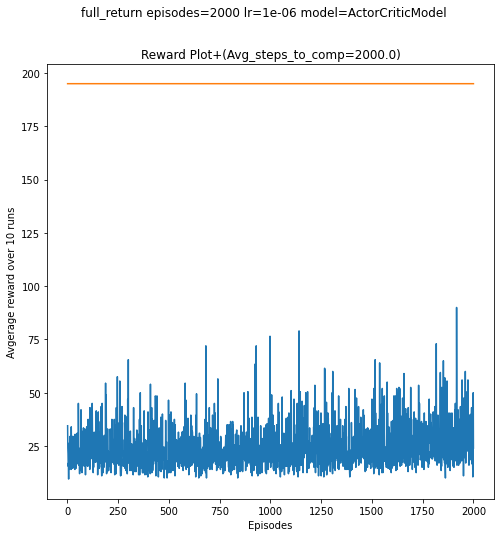

In [ ]:
env = gym.make('CartPole-v1')
reward_threshold=195 #env.spec.reward_threshold
reward_variations={"One_step":[1],"n-step":[4,16]}
reward_variations={"full_return":[1]}
learning_rate_parameters=[1e-6]
episode_parameters=[2000]
runs=2


for variation in reward_variations.keys():
  for n in reward_variations[variation]:
    for epi in episode_parameters:
      for lr in learning_rate_parameters:
            reward_variation=[]
            no_of_steps_list=[epi for i in range(runs)]
            for run in range(runs):
              state_shape = env.observation_space.shape[0]
              action_shape = env.action_space.n
              #Initializing Agent
              agent = Agent(lr=lr, action_size=env.action_space.n)
              #Number of episodes
              episodes = epi
              tf.compat.v1.reset_default_graph()

              reward_list = [reward_threshold for i in range(episodes)]
              average_reward_list = []
              
              begin_time = datetime.datetime.now()
                
              for ep in range( episodes):
                
                  avg_100 =  np.mean(reward_list[max(0,ep-20):ep])
                  if avg_100 > reward_threshold:
                      print('Stopped at Episode ',ep-20)
                      no_of_steps_list[run]=ep-20+1
                      break
                  state = env.reset().reshape(1,-1)
                  done = False
                  ep_rew = 0 
                  no_of_steps=0
                  
                  if variation=="One_step":
                    var_title=variation
                    while not done:
                      action = agent.sample_action(state) ##Sample Action
                      next_state, reward, done, info = env.step(action) ##Take action
                      next_state = next_state.reshape(1,-1)
                      ep_rew += reward  ##Updating episode reward
                      agent.learn(state, action, reward, next_state, done) ##Update Parameters
                      state = next_state ##Updating State
                      no_of_steps+=1 
                  elif variation=="full_return":
                      var_title=variation
                      curr_rew=0 
                      gam=1 
                      action_array=[]
                      state_array=[]
                      reward_array=[]
                      while not done:
                        action = agent.sample_action(state) ##Sample Action
                        next_state, reward, done, info = env.step(action) ##Take action
                        action_array.append(action)
                        state_array.append(state) 
                        reward_array.append(reward)
                        next_state = next_state.reshape(1,-1)
                        ep_rew += reward  ##Updating episode reward
                  
        
                        state = next_state ##Updating State
                        no_of_steps+=1 
                      for i in range(len(action_array)):
                        state=state_array[i]
                        curr_rew=discounted_reward(np.array(reward_array[i:]))
                        action=action_array[i]
                        agent.learn(state, action, curr_rew, next_state, done,full_return=True)
                  else: 
                      var_title=f"{n}_step_return"
                      while not done:
                        curr_rew=0 
                        gam=1
                        for i in range(n):
                          
                          
                          action = agent.sample_action(state) ##Sample Action
                          next_state, reward, done, info = env.step(action) ##Take action
                          
                          next_state = next_state.reshape(1,-1)
                          if done:
                            break 
                          curr_rew+=(reward*gam)
                          gam=gam*agent.gamma
                          ep_rew += reward 
                          no_of_steps+=1 
                          prev_state=state
                          state = next_state
                        agent.learn(prev_state, action, curr_rew, state, done,n=n)
                        

                      
                  
                  
                  reward_list[ep]=(ep_rew)
                  
                  if ep % 10 == 0:
                    print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_100,"No of steps %f" %no_of_steps)
                  
              reward_variation.append(np.array(reward_list))
              time_taken = datetime.datetime.now() - begin_time
              print(time_taken)
              if no_of_steps_list[run]==0:
                no_of_steps_list[run]=ep+1
            title=f"{var_title} episodes={epi} lr={lr} model={agent.agent_name}"
            step_variance_plots(reward_variation,no_of_steps_list,title)

In [ ]:
###

# Model 2 using LSTMS

In [9]:
class ActorCriticModel3(tf.keras.Model):
    """
    Defining policy and value networkss
    """
    def __init__(self, action_size, n_hidden1=32, n_hidden2=1024,n_hidden3=512):
        super(ActorCriticModel3, self).__init__()
        self.model_name=self.__class__.__name__ 
        #Hidden Layer 1
        self.fc1 = tf.keras.layers.LSTM(32,return_sequences=True)
        self.fc2 = tf.keras.layers.LSTM(64)

        #Hidden Layer 2
        self.fc3 = tf.keras.layers.Dense(n_hidden2, activation='relu')
        self.fc4 = tf.keras.layers.Dense(n_hidden3, activation='relu')
        
        
        #Output Layer for policy
        self.pi_out = tf.keras.layers.Dense(action_size, activation='softmax')
        #Output Layer for state-value
        self.v_out = tf.keras.layers.Dense(1)

    def call(self, state):
        """
        Computes policy distribution and state-value for a given state
        """
        layer1 = self.fc1(state)
        layer2 = self.fc2(layer1)
        layer2=self.fc3(layer2)
        layer2=self.fc4(layer2)

        pi = self.pi_out(layer2)
        v = self.v_out(layer2)

        return pi, v

In [10]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)
class Agent:
    """
    Agent class
    """
    def __init__(self, action_size, lr=0.001, gamma=0.99, seed = 85):
        self.gamma = gamma
        self.ac_model = ActorCriticModel3(action_size=action_size)
        self.ac_model.compile(tf.keras.optimizers.Adam(learning_rate=lr))
        np.random.seed(seed)
        self.agent_name=self.ac_model.model_name
        
    
    def sample_action(self, state):
        """
        Given a state, compute the policy distribution over all actions and sample one action
        """
        pi,_ = self.ac_model(state)

        action_probabilities = tfp.distributions.Categorical(probs=pi)
        sample = action_probabilities.sample()

        return int(sample.numpy()[0])

    def actor_loss(self, action, pi, delta):
        """
        Compute Actor Loss
        """
        return -tf.math.log(pi[0,action]) * delta

    def critic_loss(self,delta):
        """
        Critic loss aims to minimize TD error
        """
        return delta**2

    @tf.function
    def learn(self, state, action, reward, next_state=None, done=False,n=1,full_return=False):
        """
        For a given transition (s,a,s',r) update the paramters by computing the
        gradient of the total loss
        """
        if full_return:
          with tf.GradientTape(persistent=True) as tape:
            pi, V_s = self.ac_model(state)
            

            V_s = tf.squeeze(V_s)
            delta=reward-V_s

            loss_a = self.actor_loss(action, pi, delta)
            loss_c =self.critic_loss(delta)
            loss_total = loss_a + loss_c

          gradient = tape.gradient(loss_total, self.ac_model.trainable_variables)
          self.ac_model.optimizer.apply_gradients(zip(gradient, self.ac_model.trainable_variables))


        else:
          with tf.GradientTape(persistent=True) as tape:
              pi, V_s = self.ac_model(state)
              _, V_s_next = self.ac_model(next_state)
              loss_c =huber_loss(reward + (((self.gamma)**n)*(V_s_next*(1))),V_s)
              V_s = tf.squeeze(V_s)
              V_s_next = tf.squeeze(V_s_next)
              

              #### TO DO: Write the equation for delta (TD error)
              ## Write code below
              delta = reward + (((self.gamma)**n)*(V_s_next*(1))) - V_s
              if full_return:
                delta=reward-V_s

              loss_a = self.actor_loss(action, pi, delta)
              #loss_c =self.critic_loss(delta)
              loss_total = loss_a + loss_c

          gradient = tape.gradient(loss_total, self.ac_model.trainable_variables)
          gradient, _ = tf.clip_by_global_norm(gradient, 5.0)
          self.ac_model.optimizer.apply_gradients(zip(gradient, self.ac_model.trainable_variables))

Episode  0 Reward 22.000000 Average Reward nan No of steps 22.000000
Episode  10 Reward 20.000000 Average Reward 19.600000 No of steps 20.000000
Episode  20 Reward 18.000000 Average Reward 17.450000 No of steps 18.000000
Episode  30 Reward 14.000000 Average Reward 17.850000 No of steps 14.000000
Episode  40 Reward 54.000000 Average Reward 20.400000 No of steps 54.000000
Episode  50 Reward 87.000000 Average Reward 29.500000 No of steps 87.000000
Episode  60 Reward 60.000000 Average Reward 52.300000 No of steps 60.000000
Episode  70 Reward 48.000000 Average Reward 53.400000 No of steps 48.000000
Episode  80 Reward 28.000000 Average Reward 36.100000 No of steps 28.000000
Episode  90 Reward 23.000000 Average Reward 28.900000 No of steps 23.000000
Episode  100 Reward 22.000000 Average Reward 26.100000 No of steps 22.000000
Episode  110 Reward 20.000000 Average Reward 24.650000 No of steps 20.000000
Episode  120 Reward 24.000000 Average Reward 23.200000 No of steps 24.000000
Episode  130 Rew

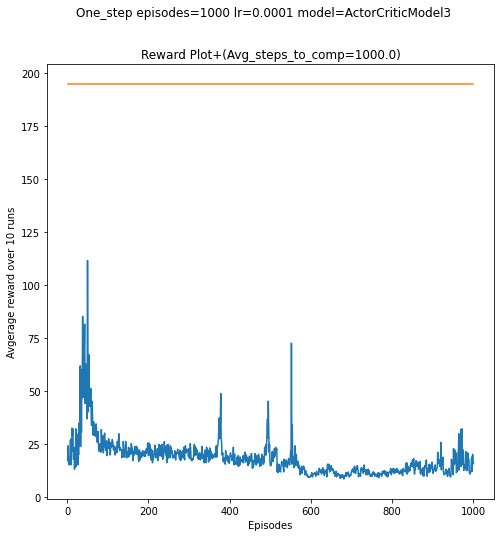

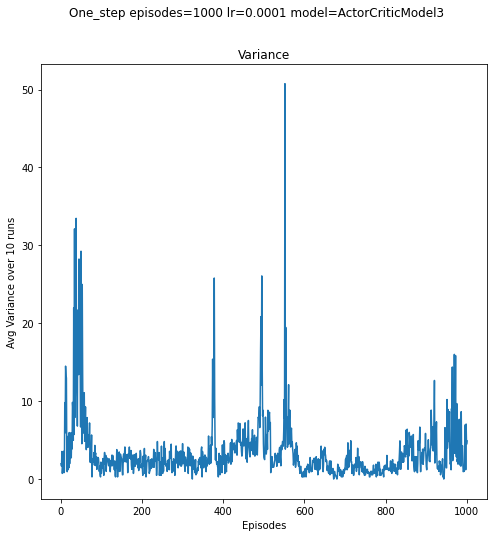

In [15]:
env = gym.make('CartPole-v1')
reward_threshold=195 #env.spec.reward_threshold
reward_variations={"One_step":[1],"n-step":[4,16]}
reward_variations={"One_step":[1]}
learning_rate_parameters=[1e-4]
episode_parameters=[1000]
runs=3


for variation in reward_variations.keys():
  for n in reward_variations[variation]:
    for epi in episode_parameters:
      for lr in learning_rate_parameters:
            reward_variation=[]
            no_of_steps_list=[epi for i in range(runs)]
            for run in range(runs):
              state_shape = env.observation_space.shape[0]
              action_shape = env.action_space.n
              #Initializing Agent
              agent = Agent(lr=lr, action_size=env.action_space.n)
              #Number of episodes
              episodes = epi
              tf.compat.v1.reset_default_graph()

              reward_list = [reward_threshold for i in range(episodes)]
              average_reward_list = []
              
              begin_time = datetime.datetime.now()
                
              for ep in range( episodes):
                
                  avg_100 =  np.mean(reward_list[max(0,ep-20):ep])
                  if avg_100 > reward_threshold:
                      print('Stopped at Episode ',ep-20)
                      no_of_steps_list[run]=ep-20+1
                      break
                  state = env.reset().reshape((1,1,-1))
                  done = False
                  ep_rew = 0 
                  no_of_steps=0
                  
                  if variation=="One_step":
                    var_title=variation
                    while not done:
                      action = agent.sample_action(state) ##Sample Action
                      next_state, reward, done, info = env.step(action) ##Take action
                      next_state = next_state.reshape((1,1,-1))
                      ep_rew += reward  ##Updating episode reward
                      agent.learn(state, action, reward, next_state, done) ##Update Parameters
                      state = next_state ##Updating State
                      no_of_steps+=1 
                  elif variation=="full_return":
                      var_title=variation
                      curr_rew=0 
                      gam=1 
                      action_array=[]
                      state_array=[]
                      reward_array=[]
                      while not done:
                        action = agent.sample_action(state) ##Sample Action
                        next_state, reward, done, info = env.step(action) ##Take action
                        action_array.append(action)
                        state_array.append(state) 
                        reward_array.append(reward)
                        next_state = next_state.reshape((1,1,-1))
                        ep_rew += reward  ##Updating episode reward
                  
        
                        state = next_state ##Updating State
                        no_of_steps+=1 
                      for i in range(len(action_array)):
                        state=state_array[i]
                        curr_rew=discounted_reward(np.array(reward_array[i:]))
                        action=action_array[i]
                        agent.learn(state, action, curr_rew, next_state, done,full_return=True)
                  else: 
                      var_title=f"{n}_step_return"
                      while not done:
                        curr_rew=0 
                        gam=1
                        for i in range(n):
                          
                          
                          action = agent.sample_action(state) ##Sample Action
                          next_state, reward, done, info = env.step(action) ##Take action
                          
                          next_state = next_state.reshape((1,1,-1))
                          if done:
                            break 
                          curr_rew+=(reward*gam)
                          gam=gam*agent.gamma
                          ep_rew += reward 
                          no_of_steps+=1 
                          prev_state=state
                          state = next_state
                        agent.learn(prev_state, action, curr_rew, state, done,n=n)
                        

                      
                  
                  
                  reward_list[ep]=(ep_rew)
                  
                  if ep % 10 == 0:
                    print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_100,"No of steps %f" %no_of_steps)
                  
              reward_variation.append(np.array(reward_list))
              time_taken = datetime.datetime.now() - begin_time
              print(time_taken)
              if no_of_steps_list[run]==0:
                no_of_steps_list[run]=ep+1
            title=f"{var_title} episodes={epi} lr={lr} model={agent.agent_name}"
            step_variance_plots(reward_variation,no_of_steps_list,title)

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode  0 Reward 18.000000 Average Reward nan No of steps 18.000000
Episode  10 Reward 11.000000 Average Reward 22.100000 No of steps 11.000000
Episode  20 Reward 23.000000 Average Reward 23.000000 No of steps 23.000000
Episode  30 Reward 15.000000 Average Reward 21.500000 No of steps 15.000000
Episode  40 Reward 12.000000 Average Reward 20.300000 No of steps 12.000000
Episode  50 Reward 13.000000 Average Reward 18.800000 No of steps 13.000000
Episode  60 Reward 13.000000 Average Reward 18.100000 No of steps 13.000000
Episode  70 Reward 15.000000 Average Reward 20.200000 No of steps 15.000000
Episode  80 Reward 10.000000 Average Reward 23.100000 No of steps 10.000000
Episode  90 Reward 9.000000 Average Reward 17.750000 No of steps 9.000000
Episode  100 Reward 23.000000 Average Reward 11.500000 No of steps 23.000000
Episode  110 Reward 10.000000 Average Reward 14.250000 No of steps 10.000000
Episode  120 Reward 17.000000 Average Reward 18.050000 No of steps 17.000000
Episode  130 Rewar

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode  0 Reward 12.000000 Average Reward nan No of steps 12.000000


Episode  10 Reward 17.000000 Average Reward 18.000000 No of steps 17.000000
Episode  20 Reward 16.000000 Average Reward 21.300000 No of steps 16.000000
Episode  30 Reward 14.000000 Average Reward 23.050000 No of steps 14.000000
Episode  40 Reward 19.000000 Average Reward 19.150000 No of steps 19.000000
Episode  50 Reward 38.000000 Average Reward 20.350000 No of steps 38.000000
Episode  60 Reward 21.000000 Average Reward 25.300000 No of steps 21.000000
Episode  70 Reward 15.000000 Average Reward 24.000000 No of steps 15.000000
Episode  80 Reward 20.000000 Average Reward 19.250000 No of steps 20.000000
Episode  90 Reward 31.000000 Average Reward 16.950000 No of steps 31.000000
Episode  100 Reward 13.000000 Average Reward 18.350000 No of steps 13.000000
Episode  110 Reward 8.000000 Average Reward 16.850000 No of steps 8.000000
Episode  120 Reward 9.000000 Average Reward 12.800000 No of steps 9.000000
Episode  130 Reward 8.000000 Average Reward 11.500000 No of steps 8.000000
Episode  140 R

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode  0 Reward 19.000000 Average Reward nan No of steps 19.000000
Episode  10 Reward 16.000000 Average Reward 28.800000 No of steps 16.000000
Episode  20 Reward 10.000000 Average Reward 27.150000 No of steps 10.000000
Episode  30 Reward 22.000000 Average Reward 23.450000 No of steps 22.000000
Episode  40 Reward 10.000000 Average Reward 23.800000 No of steps 10.000000
Episode  50 Reward 10.000000 Average Reward 19.150000 No of steps 10.000000
Episode  60 Reward 15.000000 Average Reward 18.000000 No of steps 15.000000
Episode  70 Reward 22.000000 Average Reward 23.450000 No of steps 22.000000
Episode  80 Reward 12.000000 Average Reward 24.050000 No of steps 12.000000
Episode  90 Reward 15.000000 Average Reward 21.950000 No of steps 15.000000
Episode  100 Reward 14.000000 Average Reward 22.300000 No of steps 14.000000
Episode  110 Reward 13.000000 Average Reward 24.800000 No of steps 13.000000
Episode  120 Reward 29.000000 Average Reward 22.900000 No of steps 29.000000
Episode  130 Rew

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode  0 Reward 20.000000 Average Reward nan No of steps 20.000000
Episode  10 Reward 27.000000 Average Reward 21.300000 No of steps 27.000000
Episode  20 Reward 9.000000 Average Reward 23.750000 No of steps 9.000000
Episode  30 Reward 20.000000 Average Reward 21.700000 No of steps 20.000000
Episode  40 Reward 15.000000 Average Reward 19.000000 No of steps 15.000000
Episode  50 Reward 11.000000 Average Reward 20.300000 No of steps 11.000000
Episode  60 Reward 19.000000 Average Reward 18.150000 No of steps 19.000000
Episode  70 Reward 12.000000 Average Reward 19.250000 No of steps 12.000000
Episode  80 Reward 15.000000 Average Reward 19.700000 No of steps 15.000000
Episode  90 Reward 16.000000 Average Reward 19.850000 No of steps 16.000000
Episode  100 Reward 15.000000 Average Reward 18.500000 No of steps 15.000000
Episode  110 Reward 20.000000 Average Reward 17.500000 No of steps 20.000000
Episode  120 Reward 12.000000 Average Reward 21.750000 No of steps 12.000000
Episode  130 Rewar

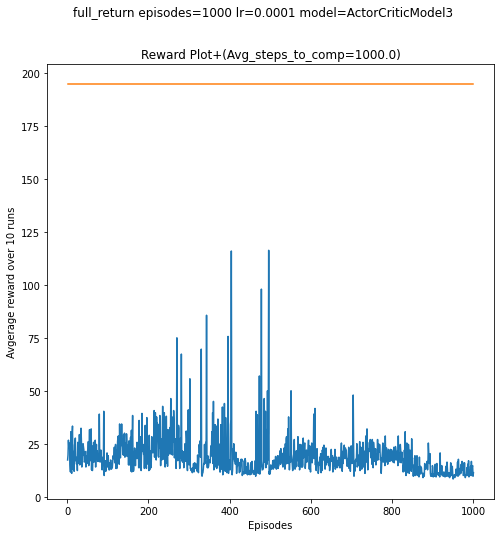

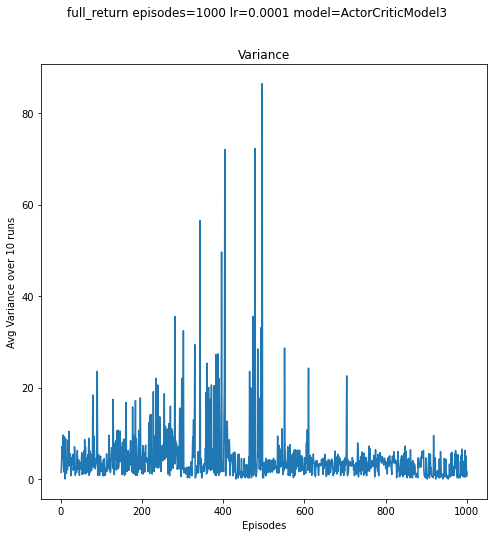

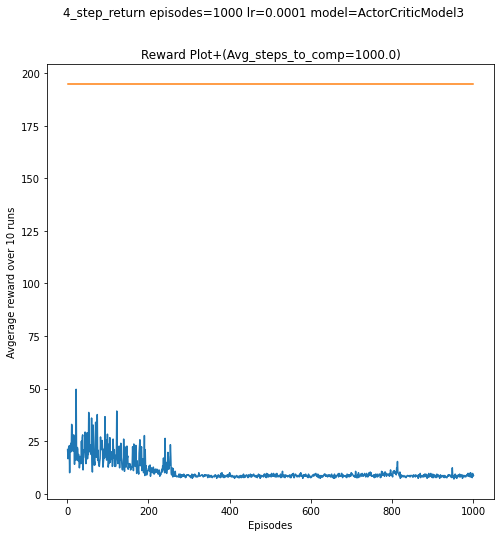

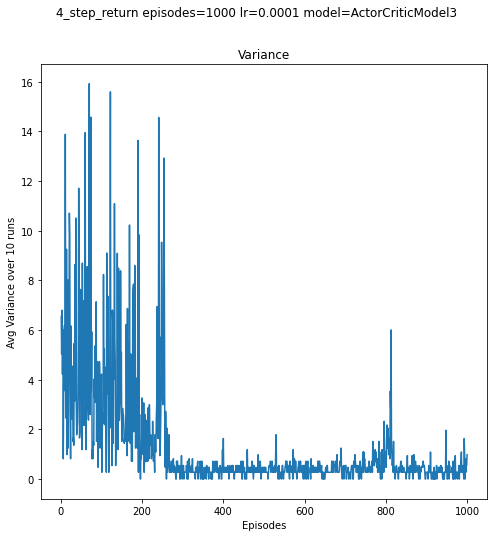

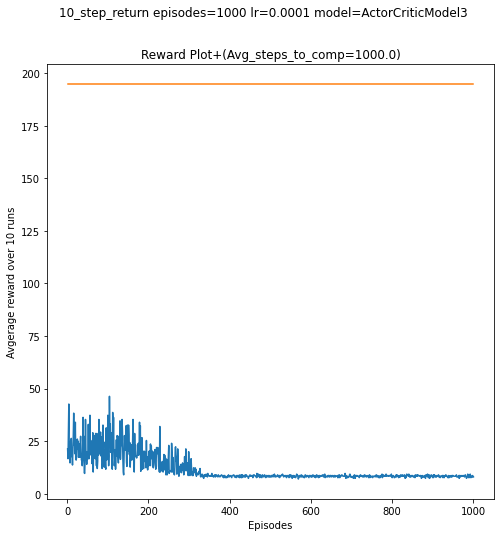

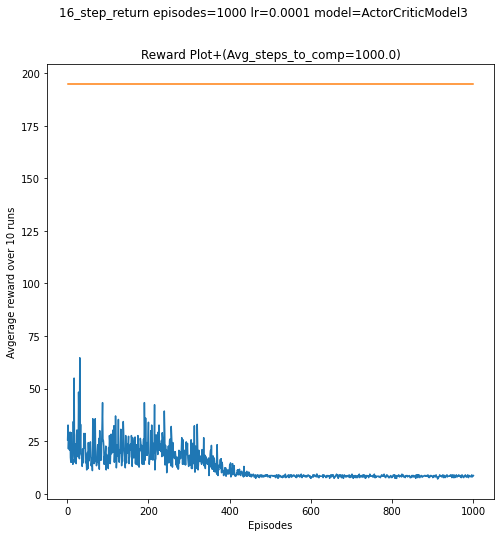

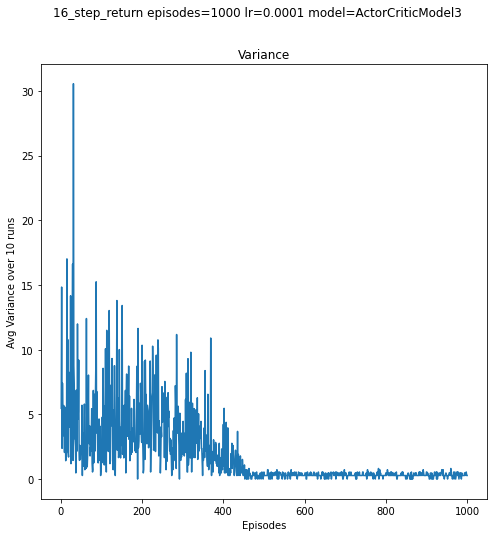

In [11]:
env = gym.make('CartPole-v1')
reward_threshold=195 #env.spec.reward_threshold
reward_variations={"One_step":[1],"n-step":[4,16]}
reward_variations={"full_return":[1],"n-step":[4,10,16]}
learning_rate_parameters=[1e-4]
episode_parameters=[1000]
runs=3


for variation in reward_variations.keys():
  for n in reward_variations[variation]:
    for epi in episode_parameters:
      for lr in learning_rate_parameters:
            reward_variation=[]
            no_of_steps_list=[epi for i in range(runs)]
            for run in range(runs):
              state_shape = env.observation_space.shape[0]
              action_shape = env.action_space.n
              #Initializing Agent
              agent = Agent(lr=lr, action_size=env.action_space.n)
              #Number of episodes
              episodes = epi
              tf.compat.v1.reset_default_graph()

              reward_list = [reward_threshold for i in range(episodes)]
              average_reward_list = []
              
              begin_time = datetime.datetime.now()
                
              for ep in range( episodes):
                
                  avg_100 =  np.mean(reward_list[max(0,ep-20):ep])
                  if avg_100 > reward_threshold:
                      print('Stopped at Episode ',ep-20)
                      no_of_steps_list[run]=ep-20+1
                      break
                  state = env.reset().reshape((1,1,-1))
                  done = False
                  ep_rew = 0 
                  no_of_steps=0
                  
                  if variation=="One_step":
                    var_title=variation
                    while not done:
                      action = agent.sample_action(state) ##Sample Action
                      next_state, reward, done, info = env.step(action) ##Take action
                      next_state = next_state.reshape((1,1,-1))
                      ep_rew += reward  ##Updating episode reward
                      agent.learn(state, action, reward, next_state, done) ##Update Parameters
                      state = next_state ##Updating State
                      no_of_steps+=1 
                  elif variation=="full_return":
                      var_title=variation
                      curr_rew=0 
                      gam=1 
                      action_array=[]
                      state_array=[]
                      reward_array=[]
                      while not done:
                        action = agent.sample_action(state) ##Sample Action
                        next_state, reward, done, info = env.step(action) ##Take action
                        action_array.append(action)
                        state_array.append(state) 
                        reward_array.append(reward)
                        next_state = next_state.reshape((1,1,-1))
                        ep_rew += reward  ##Updating episode reward
                  
        
                        state = next_state ##Updating State
                        no_of_steps+=1 
                      for i in range(len(action_array)):
                        state=state_array[i]
                        curr_rew=discounted_reward(np.array(reward_array[i:]))
                        action=action_array[i]
                        agent.learn(state, action, curr_rew, next_state, done,full_return=True)
                  else: 
                      var_title=f"{n}_step_return"
                      while not done:
                        curr_rew=0 
                        gam=1
                        for i in range(n):
                          
                          
                          action = agent.sample_action(state) ##Sample Action
                          next_state, reward, done, info = env.step(action) ##Take action
                          
                          next_state = next_state.reshape((1,1,-1))
                          if done:
                            break 
                          curr_rew+=(reward*gam)
                          gam=gam*agent.gamma
                          ep_rew += reward 
                          no_of_steps+=1 
                          prev_state=state
                          state = next_state
                        agent.learn(prev_state, action, curr_rew, state, done,n=n)
                        

                      
                  
                  
                  reward_list[ep]=(ep_rew)
                  
                  if ep % 10 == 0:
                    print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_100,"No of steps %f" %no_of_steps)
                  
              reward_variation.append(np.array(reward_list))
              time_taken = datetime.datetime.now() - begin_time
              print(time_taken)
              if no_of_steps_list[run]==0:
                no_of_steps_list[run]=ep+1
            title=f"{var_title} episodes={epi} lr={lr} model={agent.agent_name}"
            step_variance_plots(reward_variation,no_of_steps_list,title)